In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import warnings
import os
from collections import namedtuple

from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import style
style.use('seaborn')

import utils as utl

## CLOSED LOOP

** The 250 trials of free exploration (whether or not they were preceded by training) ** 

In this period we have a 2-way relation between selection (the better you learn the more you may select the task) and learning (the more you select the task, the more you learn) - which motivates the label “closed loop”. I think that for the exploratory phase we should use logistic regression to determine which factors are important for task selection.

For each participant, define y as a 250 element vector, with each element being 0 if the participant stayed on the same task as on the previous trial, and 1 if she switched tasks. Then use logistic regression to fit y = b*X. I.e., fit y as a linear combination of the factors of interest, each weighted by its fitted coefficient b.

The matrix X has the variables of interest, of which there can be many. Here is a list I propose:
- x0: baseline (average propensity to switch or stay, which may differ in interesting ways by participant)
- x1: total nb of trials played so far (switch/stay strategy may change as a function of time horizon remaining to learn)
- x2: nb of trials played in the current stretch of this task
- x3: total nb of trials played so far on the current task (in all stretches)
- x4: relative nb of trials played so far on the current task (total nb of trials on this task normalized by the mean across all tasks)
- x5: the variance in the nb of trials allocated so far to all tasks (perhaps people will tend to switch more often if their allocation so far was more skewed - i.e., they didn’t sample all the tasks - see below for explanation).
- x6: %correct on the current task in the current stretch
- x7: % correct on the current task across all the trials played so far
- x8: relative %correct on the current task (normalized by %correct for all the others)
- x9: variance in %correct across all tasks
- x10: LP on the current task in the current stretch
- x11: LP on the current task across all trials played so far
- x12: relative LP on the current task, normalized by the LP on the others
- x13: variance in LP across all tasks

**Notes**

- The terms for variance (x13, x9 and x5) are meant to capture the possibility that people switch more often if they have not sampled all the tasks. I think that a simple way to do this is to take the variable of interest (LP, %correct or nb of trials allocated) and calculate its variance across the 4 tasks; high variance indicates a skewed distribution, and low variance, more even allocation. For instance, if a participant selected tasks 1-4 for, say, 100, 2,1,1 trials, this will have high variance and indicate a highly skewed distribution, whereas if she selected tasks 1-4 for 26, 26, 26 and 26 trials, this has 0 variance and a much more uniform distribution.

- Some of the variables may not be defined for all trials. For instance, x6 and x10 are not defined on the first trial after a switch. You can leave those as missing values if the fitting algorithm can deal with that. OTherwise, I would use a heuristic of defining them as the values on the last stretch of the same task. “The last stretch” can include the training trials if necessary.
The logistic regression above can be performed individually for each participant. So, your results will have
13 coefficients * 100 participants * 5 experimental groups.

- The visualization will consist of histograms showing the distribution of each coefficient across all participants. Ideally you would organize this in one page with 13 columns (one per factor) and 5 rows (one per experimental group).

- In each histogram show with different colors the coefficients that are significantly > 0 (p < 0.05) or significantly < 0. Also show the mean of the distribution (with a vertical line) and some test comparing the mean to 0 (you may make the vertical line thick if p < 0.05 and thin otherwise). Keep the x-axis the same across rows so that we can easily see if some coefficient differed by experimental group.

** For the future **
- I think that this is the simplest and most efficient way to do exploratory analysis. When we have the coefficients, we may consider doing further dimensionality reduction (PCA analysis?) to see if participants show groups of strategies.

- Also we can consider multinomial regression, where y is not just 1 or 0, but one of the tasks (1-4). But I think this is much more complex and we can get much of the same information with the logistic regression - so I would very much want to see this one first.

## 1. Load data

In [2]:
PARENT_DIR = 'clean_data'
DATA_DIR = 'free'
FILES = os.listdir(os.path.join(PARENT_DIR, DATA_DIR))
FILENAME = [f for f in FILES if not 'extra' in f][0]
PATH = os.path.join(PARENT_DIR, DATA_DIR, FILENAME)

raw = np.loadtxt(PATH, dtype=int, delimiter=',', skiprows=1)

# Trim data
raw = raw[raw[:,1]<=250].reshape([len(np.unique(raw[:,0])),250,12])
raw = raw[:,:,1:]

## 2. Define X

In [1]:
cols = ['trial', 'cond', 'stage', 'blkt', 'fam', 'd1', 'd2', 'cat', 'cor', 'switch', 'rt']

IVs = ['mean_switch', 'nbt_total', 
       'nbt_block', 'nbt_family', 'nbt_rel', 'nbt_var', 
       'PC_block', 'PC_family', 'PC_rel', 'PC_var',
       'LP_block', 'LP_family', 'LP_rel', 'LP_var',]

CK = dict(zip(cols,list(range(len(cols)))))
IVK = dict(zip(IVs,list(range(len(IVs)))))

ns, nt, nf = raw.shape

X = np.zeros([ns,nt,len(IVs)])
unk = np.nan

# x0: baseline (simple propensity to switch)
mean_switch = np.mean(raw[:,:,CK['switch']], axis=1) # for each subject
for x, mu in zip(X, mean_switch):
    x[:, IVK['mean_switch']] = mu
    
# x1: total nb of trials played
X[:,:,IVK['nbt_total']] = raw[:,:,CK['trial']] - 1

# x2: number of trial played in the curret stretch of the task
X[:,:,IVK['nbt_block']] = raw[:,:,CK['blkt']]


for i, subj in enumerate(raw):
    fam_tally = {1:0,2:0,3:0,4:0}
    blk_cor_tally = 0
    fam_cor_tally  = {1:0,2:0,3:0,4:0}
    total_cor_tally = 0
#     fams, freqs = np.unique(subj[:,ix0], return_counts=True)
#     famfreqdict = dict(zip(fams,freqs))

    # On the first trial, do:
    ls_fam_tally = list(fam_tally.values())
    # x3: total number of trials played so far on the current family
    X[i,0,IVK['nbt_family']] = fam_tally[subj[0,CK['fam']]]

    # x4: the relative number of trials played so far on the current family 
    total = np.sum(ls_fam_tally) # <----- TODO: figure out the quantity of normalization (mean or sum?)
    X[i,0,IVK['nbt_rel']] = fam_tally[subj[0,CK['fam']]] / total if total > 0 else 1 
#         X[i,j,ix2] = famfreqdict[raw[i,j,ix0]] / np.mean(list(tally.values())) if np.sum(list(tally.values())) > 0 else 0

    # x5: the variance (std) in the number of trials allocated so far to all tasks
    X[i,0,IVK['nbt_var']] = unk # np.std(ls_fam_tally)
    
    # x6: PC on the current task and in the current block
    X[i,0,IVK['PC_block']] = unk
    
    # x7: PC on the current task for all family trials so far
    X[i,0,IVK['PC_family']] = unk
    
    # x8: PC for the current trial and current family (normalized by average PC across trials)
    X[i,0,IVK['PC_rel']] = unk
    
    for j, trial in enumerate(subj[1:]):
        jj = j+1
        fam_tally[subj[j,CK['fam']]] += 1
        total_cor_tally += subj[j,CK['cor']]
        
        ls_fam_tally = list(fam_tally.values())

        # x3: total number of trials played so far on the current family
        X[i,jj,IVK['nbt_family']] = fam_tally[trial[CK['fam']]]
        
        # x4: the relative number of trials played so far on the current family 
        total = np.sum(ls_fam_tally) # <----- TODO: figure out the quantity of normalization (mean or sum?)
        X[i,jj,IVK['nbt_rel']] = fam_tally[trial[CK['fam']]] / total if total > 0 else 1 
#         X[i,j,ix2] = famfreqdict[raw[i,j,ix0]] / np.mean(list(tally.values())) if np.sum(list(tally.values())) > 0 else 0
        
        # x5: the variance (std) in the number of trials allocated so far to all tasks
        X[i,jj,IVK['nbt_var']] = np.std(ls_fam_tally)

        # x6: PC on the current task and in the current block
        if trial[CK['switch']]: 
            blk_cor_tally = 0
            X[i,jj,IVK['PC_block']] = unk
        else:
            blk_cor_tally += subj[j,CK['cor']]
            X[i,jj,IVK['PC_block']] = blk_cor_tally / raw[i,jj,cols.index('blkt')]
            
        # x7: PC on the current task for all family trials so far
        fam_cor_tally[trial[CK['fam']]] += subj[j, CK['cor']]
        
        X[i,jj,IVK['PC_family']] = fam_cor_tally[trial[CK['fam']]] / fam_tally[trial[CK['fam']]] \
                                   if fam_tally[trial[CK['fam']]] != 0 else unk
           
        # x8: relative PC ()
        X[i,jj,IVK['PC_rel']] = X[i,jj,IVK['PC_family']] / (total_cor_tally / jj)
#         if jj < 80 and i==11:
#             print(
#                 jj, 
#                 subj[j,CK['fam']], 
#                 subj[j, CK['cor']], 
#                 list(fam_cor_tally.values()),
#                 np.sum(list(fam_cor_tally.values())),
#                 list(fam_tally.values()),
#                 sep='| ')

NameError: name 'raw' is not defined

## Sandbox

In [4]:
float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter}, threshold=5000)
print(X[11,:50,:])

[[0.02 0.00 0.00 0.00 1.00 nan nan nan nan 0.00 0.00 0.00 0.00 0.00]
 [0.02 1.00 1.00 1.00 1.00 0.43 0.00 0.00 nan 0.00 0.00 0.00 0.00 0.00]
 [0.02 2.00 2.00 2.00 1.00 0.87 0.50 0.50 1.00 0.00 0.00 0.00 0.00 0.00]
 [0.02 3.00 3.00 3.00 1.00 1.30 0.33 0.33 1.00 0.00 0.00 0.00 0.00 0.00]
 [0.02 4.00 4.00 4.00 1.00 1.73 0.50 0.50 1.00 0.00 0.00 0.00 0.00 0.00]
 [0.02 5.00 5.00 5.00 1.00 2.17 0.60 0.60 1.00 0.00 0.00 0.00 0.00 0.00]
 [0.02 6.00 6.00 6.00 1.00 2.60 0.67 0.67 1.00 0.00 0.00 0.00 0.00 0.00]
 [0.02 7.00 7.00 7.00 1.00 3.03 0.71 0.71 1.00 0.00 0.00 0.00 0.00 0.00]
 [0.02 8.00 8.00 8.00 1.00 3.46 0.75 0.75 1.00 0.00 0.00 0.00 0.00 0.00]
 [0.02 9.00 0.00 0.00 0.00 3.90 nan nan nan 0.00 0.00 0.00 0.00 0.00]
 [0.02 10.00 1.00 1.00 0.10 3.77 0.00 1.00 1.43 0.00 0.00 0.00 0.00 0.00]
 [0.02 11.00 2.00 2.00 0.18 3.70 0.50 1.00 1.38 0.00 0.00 0.00 0.00 0.00]
 [0.02 12.00 3.00 3.00 0.25 3.67 0.33 0.67 1.00 0.00 0.00 0.00 0.00 0.00]
 [0.02 13.00 4.00 4.00 0.31 3.70 0.25 0.50 0.81 0.00 0.0

In [5]:
print(raw[11,:100,:])

[[    1     0     1     0     1     6     6     3     0     1 13031]
 [    2     0     1     1     1     6     3     3     1     0  1323]
 [    3     0     1     2     1     3     4     3     0     0  1679]
 [    4     0     1     3     1     3     1     3     1     0  2976]
 [    5     0     1     4     1     6     3     3     1     0  4135]
 [    6     0     1     5     1     2     5     3     1     0  1655]
 [    7     0     1     6     1     3     2     3     1     0  1212]
 [    8     0     1     7     1     1     5     3     1     0  5233]
 [    9     0     1     8     1     6     3     3     1     0  2907]
 [   10     0     1     0     2     4     6     2     0     1  5623]
 [   11     0     1     1     2     6     5     2     1     0  1144]
 [   12     0     1     2     2     2     3     2     0     0  1597]
 [   13     0     1     3     2     1     6     2     0     0  2505]
 [   14     0     1     4     2     3     2     2     0     0  1897]
 [   15     0     1     5     2   

<IPython.core.display.Javascript object>


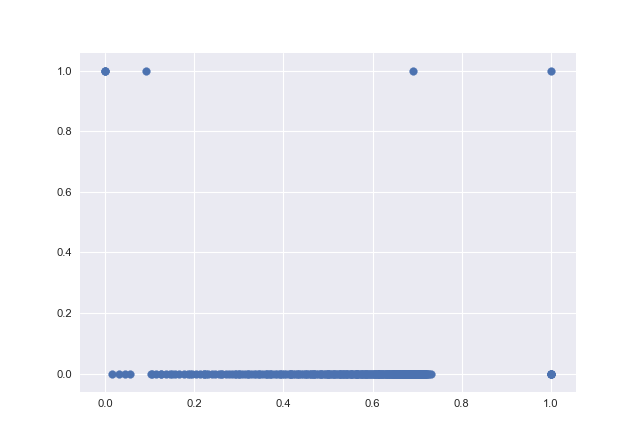

In [29]:
x_ = X[12,:,IVK['nbt_rel']]
y_ = raw[12,:,CK['switch']]

plt.scatter(x_,y_)